In [2]:
!pip install BerryEasy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pybinding: filename=pybinding-0.9.5-cp310-cp310-linux_x86_64.whl size=1033752 sha256=6e7c6ef3d8e8035301b503032526980be11fc8579af1a01cde63653c63ac6c2c
  Stored in directory: /root/.cache/pip/wheels/e7/42/97/1f8177173309e928f2b6aad57d26477a259eb415af30e7fb81
Successfully built pybinding


In [5]:
import pybinding as pb
from BerryEasy import BerryEasy as be
import numpy as np
#import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Let us implement the tight-binding model of a spinful qudrupolar insulator

Text(0.5, 0, '')

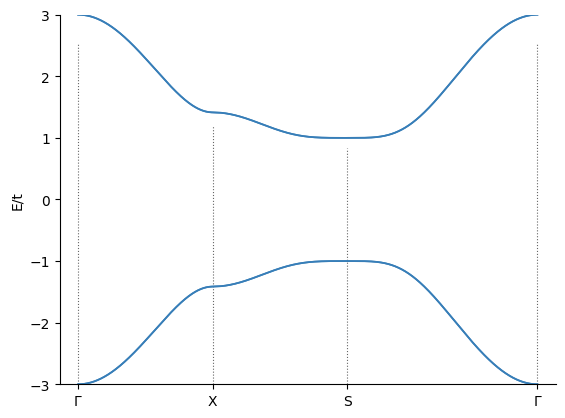

In [6]:

S0=np.array([[1,0],[0,1]])
S1=np.array([[0,1],[1,0]])
S2=np.array([[0,-1j],[1j,0]])
S3=np.array([[1,0],[0,-1]])
from math import pi
g_1 =np.kron(S1,S3)
g_2=np.kron(S2,S3)
g_4=np.kron(S0,S1)
g_5= np.kron(S3,S3)
#do=np.kron(np.diag([e1,e2]),S3)


D=0.5

Tx=(1j*g_1+g_5+D*g_4)/2
Ty=(-1j*g_2+g_5-D*g_4)/2
U=(1*g_5)



lat=pb.Lattice(a1=[1,0],a2=[0,1])
lat.add_sublattices(('A', [0,0],U ))
lat.add_hoppings(
                     ([1,0], 'A', 'A', Tx),
                     ([0,1], 'A', 'A', Ty)
                    )
lattice = lat

model = pb.Model(lat,
        pb.primitive(a1=1,a2=1),
        pb.translational_symmetry(a1=True, a2=True))
solver = pb.solver.lapack(model)


X = [pi,0]
Gamma = [0,0]
Z = [0,pi]
M= [pi,pi]


#plt.rcParams["font.family"] = "Times New Roman"
#plt.rcParams.update({'font.size': 20})
bands = solver.calc_bands(  Gamma, X, M, Gamma, step=0.01)
bands.plot(point_labels=[ r'$\Gamma$','X', 'S', '$\Gamma$'])
plt.ylabel("E/t")
plt.ylim(-3,3)
plt.xlabel("")

In [ ]:
# We can now examine the bandstructure after applying the chiral symmetry preserving perturbation

In [ ]:
L=1
model = pb.Model(lat,
                 pb.force_double_precision(),
                pb.primitive(L,L),
                pb.translational_symmetry(a1=L, a2=L))
solver=pb.solver.lapack(model)
positions=np.array(getattr(getattr(model, 'system'),'positions'))
pot=[]
pot2=[]
w=2
for j in range(np.shape(positions)[1]):
    pot.append(np.random.uniform(low=(-w/2), high=(w/2)))
    pot2.append(np.random.uniform(low=(-w/2), high=(w/2)))
def disorder():
    @pb.onsite_energy_modifier
    def potential(energy, x, y):
        v=0
        for i in range(np.shape(positions)[1]):
            xpos=positions[0][i]
            ypos=positions[1][i]
            v=v+(np.heaviside(-np.absolute(x-xpos),1))*(np.heaviside(-np.absolute(y-ypos),1))*np.kron(np.diag([pot[i],pot2[i]]),S3)
        return energy + v
    return potential
model = pb.Model(lat,
    pb.primitive(L,L),
     disorder(),
    pb.force_double_precision(),
    pb.translational_symmetry(a1=L, a2=L))
solver = pb.solver.lapack(model)
X = [pi,0]
Gamma = [0,0]
Z = [0,pi]
M= [pi,pi]


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 20})
bands = solver.calc_bands(  Gamma, X, M, Gamma, step=0.01)
bands.plot(point_labels=[ r'$\Gamma$','X', 'S', '$\Gamma$'])
plt.ylabel("E/t")
plt.ylim(-3,3)
plt.xlabel("")
plt.show()

In [ ]:
# Let us introduce disorder through pybinding onsite modifier and compute the density of states using the built in KPM solver:

In [ ]:
L=100
model = pb.Model(lat,
                 pb.force_double_precision(),
                pb.primitive(L,L),
                pb.translational_symmetry(a1=L, a2=L))
solver=pb.solver.lapack(model)
positions=np.array(getattr(getattr(model, 'system'),'positions'))
BulkAvgDos=[]
for w in tqdm(np.linspace(0.05,10,20)):
    avgres=np.zeros(1)
    iteration=0
    while iteration<50:
        pot=[]
        pot2=[]
        for j in range(np.shape(positions)[1]):
            pot.append(np.random.uniform(low=(-w/2), high=(w/2)))
            pot2.append(np.random.uniform(low=(-w/2), high=(w/2)))
        def disorder():
            @pb.onsite_energy_modifier
            def potential(energy, x, y):
                v=0
                for i in range(np.shape(positions)[1]):
                    xpos=positions[0][i]
                    ypos=positions[1][i]
                    v=v+(np.heaviside(-np.absolute(x-xpos),1))*(np.heaviside(-np.absolute(y-ypos),1))*np.kron(np.diag([pot[i],pot2[i]]),S3)
                return energy + v
            return potential
        model = pb.Model(lat,
            pb.primitive(L,L),
             disorder(),
            pb.force_double_precision(),
            pb.translational_symmetry(a1=L, a2=L))
        solver = pb.kpm(model)
        ldos = solver.calc_dos([0], broadening=0.01)
        result=getattr(ldos,'data')
        avgres=avgres+result
        if iteration==49:
            BulkAvgDos.append(avgres/50)
        iteration=iteration+1

In [ ]:

#plt.rcParams["font.family"] = "Times New Roman"
#plt.rcParams.update({'font.size': 12})
plt.plot(np.linspace(0.05,10,20),BulkAvgDos,'--',c='red')
plt.xlabel('W')
plt.ylabel(r'$\rho_{Avg}(0) (arb. units)$')
plt.tight_layout()

Now let us investigate the effecton bulk topology

In [ ]:
#Note computation time is long for large L, for quick check it is best to limit the system size but beware of corresponding finite size disorder effects
s3=cp.diag([1,-1])
s0=cp.diag([1,1])
BulkC1=[]
BulkC2=[]
for w in tqdm(np.linspace(0,10,11)):
    print(w)
    BulkCA=[]
    BulkCB=[]
    for LA in np.linspace(11,31,1):
        L=int(LA)
        model = pb.Model(lat,
                     pb.force_double_precision(),
                    pb.primitive(L,L),
                    pb.translational_symmetry(a1=L, a2=L))
        solver=pb.solver.lapack(model)
        positions=np.array(getattr(getattr(model, 'system'),'positions'))
        avgres=[]
        avgres2=[]
        iteration=0
        while iteration<1:
            pot=[]
            pot2=[]
            for j in range(np.shape(positions)[1]):
                pot.append(np.random.uniform(low=(-w/2), high=(w/2)))
                pot2.append(np.random.uniform(low=(-w/2), high=(w/2)))
            def disorder():
                @pb.onsite_energy_modifier
                def potential(energy, x, y):
                    v=0
                    for i in range(np.shape(positions)[1]):
                        xpos=positions[0][i]
                        ypos=positions[1][i]
                        v=v+(np.heaviside(-np.absolute(x-xpos),1))*(np.heaviside(-np.absolute(y-ypos),1))*np.kron(np.diag([pot[i],pot2[i]]),S3)
                    return energy + v
                return potential
            model = pb.Model(lat,
                pb.primitive(L,L),
                 disorder(),
                pb.force_double_precision(),
                pb.translational_symmetry(a1=L, a2=L))
            solver = pb.solver.lapack(model)
            plaquettes=20
            rvec1=2*np.pi/L
            rvec2=2*np.pi/L
            dsx=((np.pi/L)/(plaquettes))
            dsy=((np.pi/L)/(plaquettes))
            kp1=np.linspace(dsx,rvec1-dsx,plaquettes)
            kp2=np.linspace(dsy,rvec2-dsy,plaquettes)
            bnds=range(2*L*L)
            WCCtemp=[]
            op=cp.kron(cp.diag(cp.ones(L*L)),cp.kron(s0,s3))
            for kx in tqdm(kp1):
                for ky in kp2:
                  #Option to select filling based on energy
                  #Ev=solver.eigenvalues
                  #index=np.argmin(np.abs(Ev))
                  #if Ev[index]<0:
                  #  bnds=range(int(index+1))
                  #else:
                  #  bnds=range(index)
                  kpts=np.array([[kx-dsx,ky-dsy,0],[kx+dsx,ky-dsy,0],[kx+dsx,ky+dsy,0],[kx-dsx,ky+dsy,0]])
                  WCCtemp.append(be.WSpinLine(kpts,model,bnds,op))
            chern=[]
            for j in range(np.shape(WCCtemp)[0]):
                chern.append(np.imag(np.log(np.exp(1j*np.sum(WCCtemp[j])))))
            avgres.append(chern)
            print(np.sum(chern))
            avgres2.append(np.sum(chern))
            print(np.mean(avgres2))
            if iteration==0:
                BulkCA.append(avgres)
                BulkCB.append(np.mean(avgres2))
            iteration=iteration+1

    BulkC1.append(BulkCA)
    BulkC2.append(BulkCB)

In [ ]:
plt.plot(BulkC3,'o',c='red')
plt.plot(BulkC3,'--',c='red')
plt.plot(np.ones(12),'--',c='black')
plt.plot(np.zeros(12),'--',c='black')
plt.xlim(0,10)
plt.xlabel('W')
plt.ylabel(r'$\mathcal{C}_{s}$')
plt.tight_layout()
#plt.savefig('Disorder_Spin_Chern.png')
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(11, 1)